In [1]:
from google.colab import files
uploaded=files.upload()

Saving dataset.zip to dataset.zip


In [2]:
import zipfile

with zipfile.ZipFile("/content/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [3]:
from google.colab import files
uploaded=files.upload()

Saving unet_colorizer.pth to unet_colorizer.pth


In [5]:
import os, json
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn

In [6]:
class PolygonColorDataset(torch.utils.data.Dataset):
    def __init__(self, input_dir, output_dir, json_path, transform=None):
        with open(json_path) as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform
        self.color_names = sorted(list(set(d['colour'] for d in self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        input_img = Image.open(os.path.join(self.input_dir, entry['input_polygon'])).convert("L")
        target_img = Image.open(os.path.join(self.output_dir, entry['output_image'])).convert("RGB")

        color_vec = torch.zeros(len(self.color_names))
        color_vec[self.color_names.index(entry['colour'])] = 1

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, color_vec, target_img

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU()
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, color_vec):
        b, _, h, w = x.shape
        color_img = color_vec.unsqueeze(2).unsqueeze(3).expand(b, color_vec.shape[1], h, w)
        x = torch.cat([x, color_img], dim=1)

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)

In [9]:
from google.colab import files
uploaded=files.upload()

Saving color_names.pkl to color_names.pkl


In [10]:
import pickle

with open("/content/color_names.pkl", "rb") as f:
    color_names = pickle.load(f)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

val_data = PolygonColorDataset(
    input_dir="/content/dataset/validation/inputs",
    output_dir="/content/dataset/validation/outputs",
    json_path="/content/dataset/validation/data.json",
    transform=transform
)
val_data.color_names = color_names

model = UNet(in_channels=1 + len(color_names), out_channels=3).to(device)
model.load_state_dict(torch.load("/content/unet_colorizer.pth", map_location=device))
model.eval()

UNet(
  (enc1): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [13]:
input_img, color_vec, target_img = val_data[0]

In [14]:
input_img = input_img.unsqueeze(0).to(device)
color_vec = color_vec.unsqueeze(0).to(device)

In [15]:
with torch.no_grad():
    output = model(input_img, color_vec)

In [16]:
output_img = output.squeeze(0).cpu().permute(1, 2, 0).numpy()
output_img = np.clip(output_img, 0, 1)

In [17]:
def show_images(input_img, target_img, output_img):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(input_img.squeeze().cpu(), cmap='gray')
    axs[0].set_title("Input Polygon")
    axs[0].axis("off")

    axs[1].imshow(target_img.permute(1, 2, 0).cpu())
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    axs[2].imshow(output_img)
    axs[2].set_title("Model Prediction")
    axs[2].axis("off")

    plt.show()

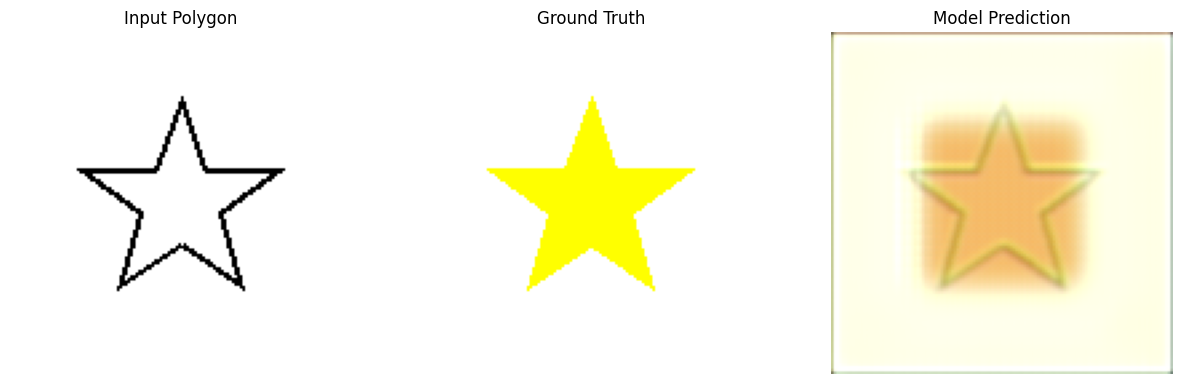

In [18]:
show_images(input_img, target_img, output_img)

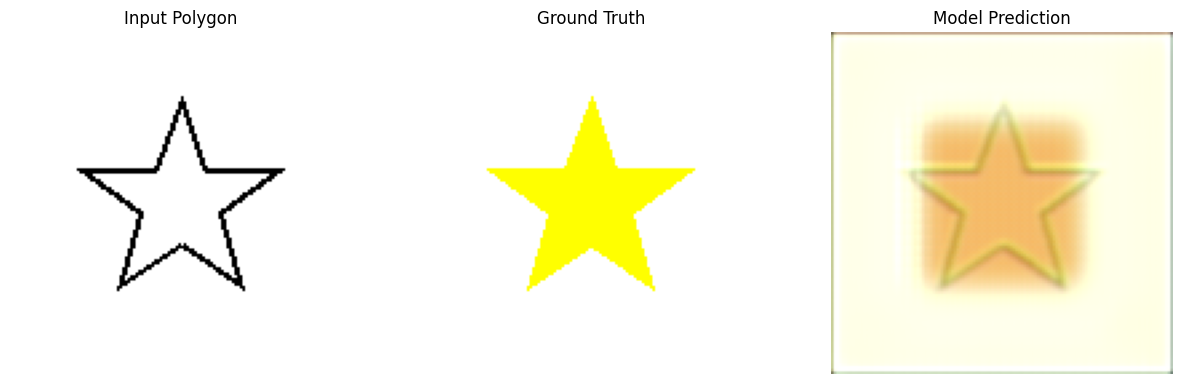

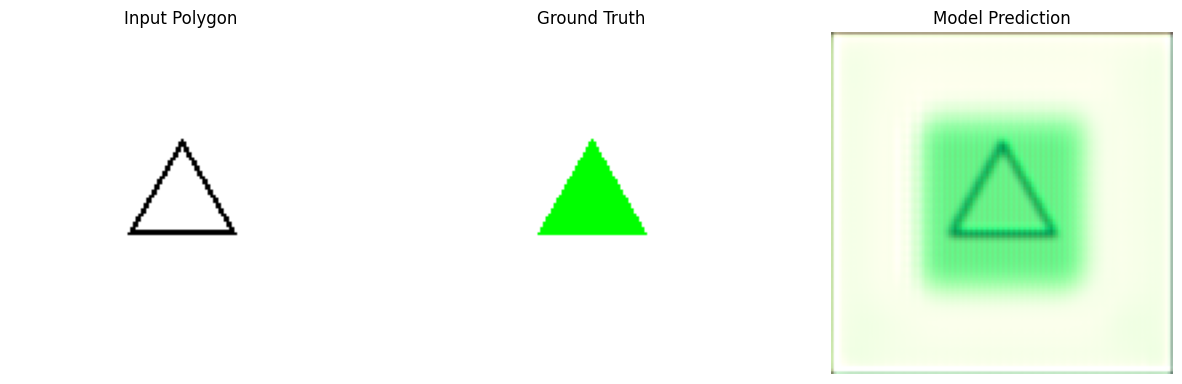

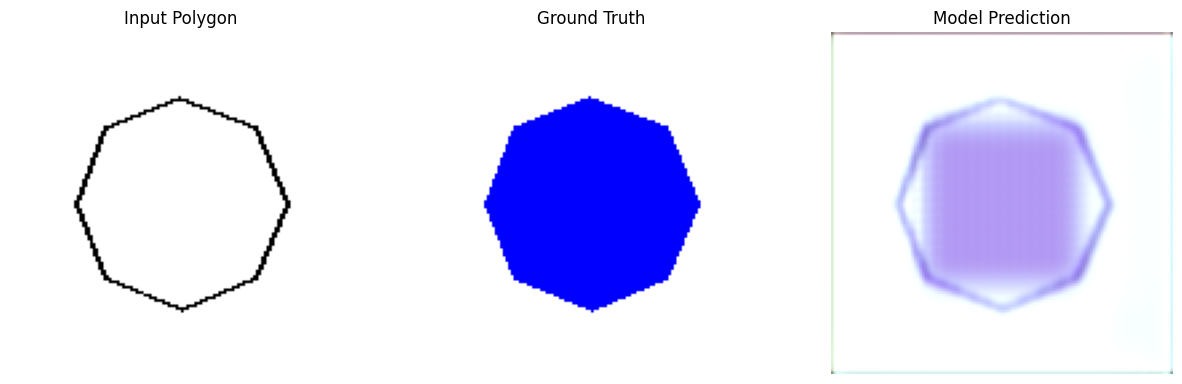

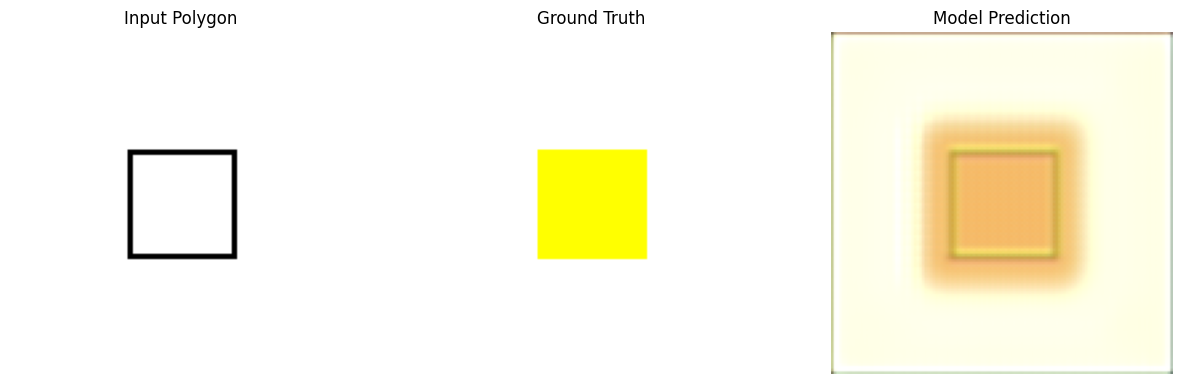

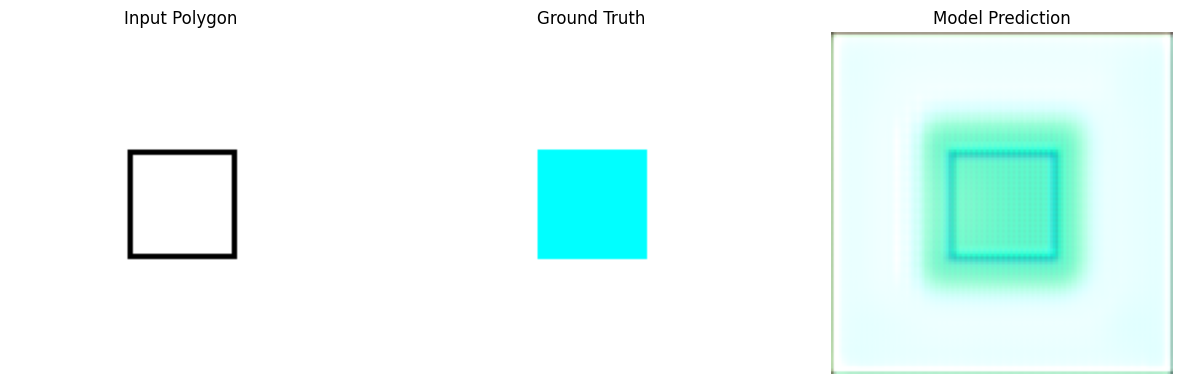

In [19]:
for i in range(5):
    input_img, color_vec, target_img = val_data[i]
    input_img_batch = input_img.unsqueeze(0).to(device)
    color_vec_batch = color_vec.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img_batch, color_vec_batch)

    output_img = output.squeeze(0).cpu().permute(1, 2, 0).numpy()
    output_img = np.clip(output_img, 0, 1)

    show_images(input_img, target_img, output_img)